<a href="https://colab.research.google.com/github/i11umin8/BtcPricePrediction/blob/main/Bitcoin_Price_Prediction_Using_A_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Bitcoin Price Prediction System
This report contains code that imports price data on bitcoin, and uses it to train a machine learning model for price prediction. In addition, we have created charting functionality to visualize the price data and predictions, along with additional visualizations to evaluate our results.

This notebook will automatically download historical bitcoin data from a CSV file located in google drive.

To run the report yourself, please click the "play" buttons next to the code snippets below. Although some of them may work independently, these are meant to be run in sequential order.

Let's begin by importing our data as a Pandas DataFrame. While we are at it, we will install a dependency we will need to visualize the data later. Please run the code snippet below to begin:

In [ ]:
# Install a missing dependency
%pip install mplfinance

# we use pandas for data manipulation
import pandas as pd
# and gdown to fetch the file from google drive
import gdown

# download file
filename = "data.csv"
file_id = '1WsfQPVA2ayssR1-M5hNntixYyAyOiw7u'
gdown.download(id=file_id, output=filename, quiet=False)

# load the bitcoin data into a pandas dataframe.

price_data = pd.read_csv(filename)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.3 MB/s eta 0:00:00


Downloading...
From (original): https://drive.google.com/uc?id=1WsfQPVA2ayssR1-M5hNntixYyAyOiw7u
From (redirected): https://drive.google.com/uc?id=1WsfQPVA2ayssR1-M5hNntixYyAyOiw7u&confirm=t&uuid=b5854dce-4c62-4265-b7de-201627fd0de2
To: /content/data.csv
100%|██████████| 190M/190M [00:03<00:00, 57.0MB/s]




Now that our data has been imported, let's take a look at the first several rows to gain understanding of the structure. We will immediately see some problems with our dataset:

In [ ]:
price_data.head(20)


,Unnamed: 0,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2625857,1483257660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2625858,1483257720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2625859,1483257780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2625860,1483257840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2625861,1483257900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2625862,1483257960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2625863,1483258020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2625864,1483258080,964.96,964.96,964.96,964.96,13.613500,13136.482960,964.960000
8,2625865,1483258140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2625866,1483258200,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Use Timestamps for Indexing
As you can see, there are a few problems with our dataset. Not only are the timestamps in unix format, but many of the rows in the early days are filled with null values. This means that price information was not available during that time.

In addition, the row number of our csv file became a column in our dataframe. That is not very useful to us, and it can safely be removed.

We will start by transforming the data. Let's first transform the timestamps into datetime objects, and then add them into their own column.

While we are at it, we can set the index of this dataframe to be these human-readable time objects. This will come in handy when we graph this data later.

In [ ]:
import datetime as dt
price_data.rename(columns={"Timestamp":"UnixTime"}, inplace=True)
price_data["Timestamp"] = price_data["UnixTime"].apply(lambda unixTime: dt.datetime.fromtimestamp(unixTime))
price_data = price_data.set_index("Timestamp")
price_data = price_data.drop(columns=["UnixTime", "Unnamed: 0"])

## Drop the Redundant Volume Column
As seen in the output above, this dataset has multiple columns representing volume. One of the volume columns is the volume in terms of US Dollars, while the other is in terms of bitcoin traded.

We can remove the US Dollar volume column, and rename the bitcoin volume column to "Volume", so that it may be used when we chart this price information later

In [ ]:
price_data.rename(columns={"Volume_(BTC)":"Volume"}, inplace=True)
price_data.drop(columns=["Volume_(Currency)"], inplace=True)

## Add Lagging Price Data
Our model will take price information from the previous time interval, and use it as input to predict the current time interval's closing price.

In order to model this correctly, we must add "lagged features". These are inputs to a machine learning model that come from a previous point in time. In our case, we need to add the previous row's price information to our dataset. We will also use the previous time interval's volume and weighted price.

In [ ]:
price_data["Previous_Close"] = price_data["Close"].shift(1)
price_data["Previous_Open"] = price_data["Open"].shift(1)
price_data["Previous_High"] = price_data["High"].shift(1)
price_data["Previous_Low"] = price_data["Low"].shift(1)
price_data["Previous_Volume"] = price_data["Volume"].shift(1)
price_data["Previous_Weighted_Price"] = price_data["Weighted_Price"].shift(1)

In [ ]:
price_data.head(20)

,Open,High,Low,Close,Volume,Weighted_Price,Previous_Close,Previous_Open,Previous_High,Previous_Low,Previous_Volume,Previous_Weighted_Price
Timestamp,,,,,,,,,,,,
2017-01-01 08:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:08:00,964.96,964.96,964.96,964.96,13.613500,964.960000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 08:09:00,NaN,NaN,NaN,NaN,NaN,NaN,964.96,964.96,964.96,964.96,13.613500,964.960000


We now have every column we need, but we still need to deal with null values. They cannot be used as input to our prediction model.

In the next section, we will handle these undefined values.

## Remove Incomplete and Misleading Data
Now we have every column necessary for our machine learning model, but we have not yet addressed the missing data that occurs in many rows. The data from the early days of bitcoin is very sparse, and less relevant to modern price action. From a cursory glance through the dataset, we can see that the vast majority, if not all of the missing rows, occur before 2018. So, let's remove any rows before 2018, along with any rows that have missing price data. This will give us a usable dataset without any missing values, that is more relevant to current price patterns:

In [ ]:
price_data = price_data.loc[dt.datetime(2018,1,1):]
price_data = price_data.dropna(subset=["Close", "Open", "High", "Low", "Volume", "Weighted_Price", "Previous_Close", "Previous_Open", "Previous_High", "Previous_Low", "Previous_Volume", "Previous_Weighted_Price"])

As a sanity check, let's view the top of the dataset one more time, to make sure it is consistent with our standards. The code below logs any rows with null values (which should be none), along with the first several rows of the dataset.

In [ ]:
print(price_data[price_data.isna().any(axis=1)])
price_data.head()

Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Weighted_Price, Previous_Close, Previous_Open, Previous_High, Previous_Low, Previous_Volume, Previous_Weighted_Price]
Index: []


,Open,High,Low,Close,Volume,Weighted_Price,Previous_Close,Previous_Open,Previous_High,Previous_Low,Previous_Volume,Previous_Weighted_Price
Timestamp,,,,,,,,,,,,
2018-01-01 00:00:00,13880.00,13906.37,13841.00,13841.01,4.967997,13895.081610,13880.00,13913.28,13913.28,13867.18,0.591748,13888.274052
2018-01-01 00:01:00,13841.01,13890.43,13841.01,13890.43,1.665850,13845.237237,13841.01,13880.00,13906.37,13841.00,4.967997,13895.081610
2018-01-01 00:02:00,13846.64,13890.35,13846.64,13847.51,0.269346,13884.349123,13890.43,13841.01,13890.43,13841.01,1.665850,13845.237237
2018-01-01 00:03:00,13847.51,13874.92,13823.19,13823.19,1.155274,13837.650132,13847.51,13846.64,13890.35,13846.64,0.269346,13884.349123
2018-01-01 00:04:00,13823.19,13826.75,13803.20,13803.20,0.646691,13809.482390,13823.19,13847.51,13874.92,13823.19,1.155274,13837.650132


We now have a dataset that has been thoroughly sanitized.

The reader may be wondering why we are keeping all of the price data for the current time interval, when we only need previous price data, the current closing price data, and volume data as input for our model.

The reason is simple: in order to visualize the price action of bitcoin, we need the current time interval's price data. This will be demonstrated in the next section of the report.

# Data Visualization

In order for our traders to gain an intuitive understanding of the data, along with our predictions, we need to chart it. We can chart this information using a simple python library known as mplfinance. A simple charting cell has been included below. This will chart bitcoin data in a line graph. Our dataset contains a significant amount of rows, so in order to create a readable graph, let's narrow down the scope of data shown to a single year. Run the code below and input the desired year. Then, run the following code cell to generate the chart.

Note: The dataset ends in March 2021. If you select 2021, the chart will not show an entire year's worth of data.

In [ ]:
year = int(input("Please pick a Year Between 2018 and 2021 (Default: 2019)\n") or 2019)
while not 2019 <= year <= 2021:
  print("Invalid Selection")
  year = int(input("Please pick a Year Between 2018 and 2021 (Default: 2019)\n") or 2019)


Please pick a Year Between 2018 and 2021 (Default: 2019)



Now that we have a year, we can generate a chart

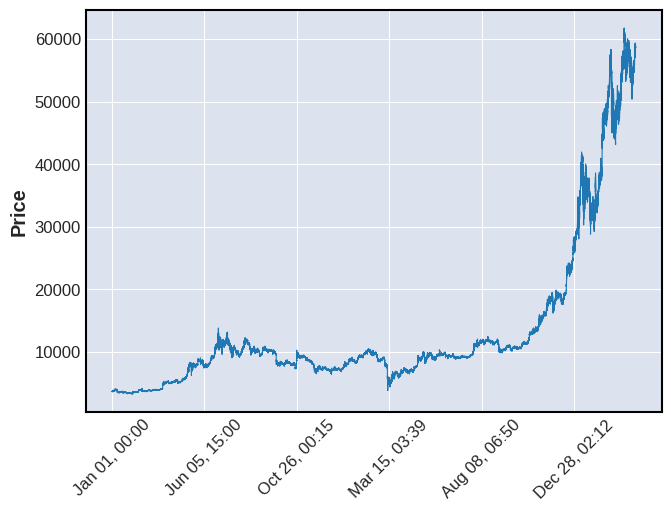

In [ ]:

import mplfinance as mplf
import datetime as dt
year_date = dt.datetime(year=int(year), month=1, day=1)
end_date = dt.datetime(year=int(year)+1, month=1, day=1)
year_data = price_data.loc[year_date:]
mplf.plot(year_data, type="line")

Now we have the capability to visualize this data for a long period of time. However, because we are operating on one-minute intervals, this data is tailored towards trading on smaller time scales. Let's create a new chart on a single-day timescale, using Japanese candle notation instead of a line.

Japanese candle notation is very similar to box-and-whisker plots. Each time interval will be charted using opening price, closing price, high price, and low price. The boundaries of the candle will be defined by the open and close price. The wicks of the candles show the high and low for the given time interval. If the closing price of the candle is above the opening price, the candle will be green. If it is lower, than it will be red. This allows us to quickly and intuitively understand price action for a period of time.

Please pick a day between January 1st 2017 and March 31st 2021, along with and an hour of the day, to generate a candle chart for our data:

In [ ]:
import datetime
year = int(input("Please pick a Year Between 2017 and 2021 (Default: 2019)\n") or 2019)
month = int(input("Please pick a month between 1 and 12 (Default: 3)\n") or 3)
day = int(input("Please pick a day between 1 and 31 (Default: 15)\n") or 15)
day = datetime.date(year, month, day)

Please pick a Year Between 2017 and 2021 (Default: 2019)

Please pick a month between 1 and 12 (Default: 3)

Please pick a day between 1 and 31 (Default: 15)



In [ ]:
hour = int(input("Please pick an hour between 0 and 23 (Default: 5)\n") or 5)

Please pick an hour between 0 and 23 (Default: 5)



Now that you've picked a day and time, we can proceed with graphing the data.

In order to make this tool maximally valuable for our traders, we can also plot some additional information besides price. Let's also plot the the volume weighted average price, so we can gain an understanding on the true price at any given time. In addition, we can use the volume data to create a bar chart at the bottom of this graph, showing how much bitcoin has been traded for a given time interval:

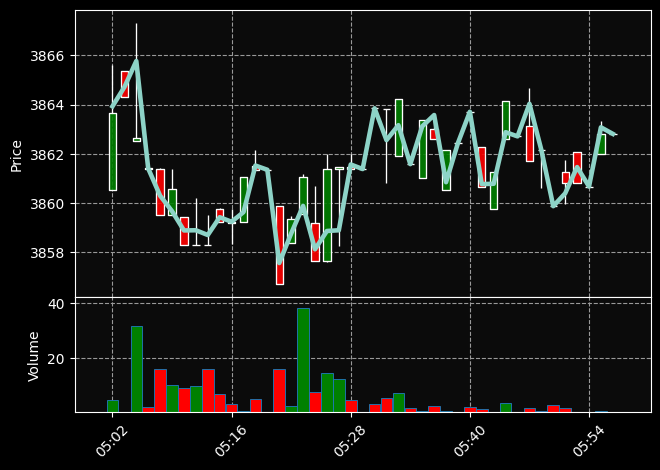

In [ ]:

try:
    day = dt.datetime.combine(day, dt.datetime.min.time())
    day = day.replace(hour=int(hour))
    end = day + dt.timedelta(hours=1)

    hourly = price_data.loc[day:end]
    mc = mplf.make_marketcolors(up='g',down='r',edge='white',volume='in',wick="white",ohlc='black')
    s  = mplf.make_mpf_style(marketcolors=mc, base_mpf_style='nightclouds')
    apdict = mplf.make_addplot(hourly['Weighted_Price'])
    mplf.plot(hourly, type="candle",  volume=True, style=s, addplot=apdict)
except:
    print("Failed to render chart. Did you select a day and hour in the inputs above?")

We have successfully plotted the price data, along with the volume and volume weighted average price.

Now that we are confident that our traders will be able to visualize the price action of bitcoin, we can proceed onto the creation of our neural network.

# The Prediction Model
We can finally move on to defining our machine learning model. We will use a simple neural network for this task.

This neural network will take 4 inputs: the previous time-interval's high price, low price, volume, and weighted price.

Using this data from the previous minute, we will attempt to predict the closing price of the current minute.

We will start by creating a simple neural network with 4 inputs, one hidden layer, and a single output:

In [ ]:
import torch
from torch import nn as nn


class BTCNetwork(nn.Module):
    def __init__(self, dtype=torch.float32):
        super(BTCNetwork, self).__init__()
        self.linear_lru = nn.Sequential(
            nn.Linear(4, 8, dtype=dtype),
            nn.Linear(8, 4, dtype=dtype),
            nn.Linear(4, 1, dtype=dtype),
        )

    def forward(self, x):
        return self.linear_lru(x)

We now have a prediction model, ready to train. The "previous" columns will be used as inputs to our model, which will then attempt to predict the closing price.

Before we begin, we can make some slight changes to our dataset, to make it a little less complex. We no longer need the volume, weighted price, or open columns at this point. Let's drop those columns. In addition, we can rearrange our columns so that our prediction column (closing price) is on the far right:


In [ ]:
price_data.head()

,Open,High,Low,Close,Volume,Weighted_Price,Previous_Close,Previous_Open,Previous_High,Previous_Low,Previous_Volume,Previous_Weighted_Price
Timestamp,,,,,,,,,,,,
2018-01-01 00:00:00,13880.00,13906.37,13841.00,13841.01,4.967997,13895.081610,13880.00,13913.28,13913.28,13867.18,0.591748,13888.274052
2018-01-01 00:01:00,13841.01,13890.43,13841.01,13890.43,1.665850,13845.237237,13841.01,13880.00,13906.37,13841.00,4.967997,13895.081610
2018-01-01 00:02:00,13846.64,13890.35,13846.64,13847.51,0.269346,13884.349123,13890.43,13841.01,13890.43,13841.01,1.665850,13845.237237
2018-01-01 00:03:00,13847.51,13874.92,13823.19,13823.19,1.155274,13837.650132,13847.51,13846.64,13890.35,13846.64,0.269346,13884.349123
2018-01-01 00:04:00,13823.19,13826.75,13803.20,13803.20,0.646691,13809.482390,13823.19,13847.51,13874.92,13823.19,1.155274,13837.650132


In [ ]:

price_data = price_data.drop(columns=["Volume","Weighted_Price"])
price_data = price_data[["Open", "High", "Low", "Previous_Close", "Previous_Open", "Previous_High", "Previous_Low", "Previous_Volume", "Previous_Weighted_Price", "Close"]]

In [ ]:
price_data.head()

,Open,High,Low,Previous_Close,Previous_Open,Previous_High,Previous_Low,Previous_Volume,Previous_Weighted_Price,Close
Timestamp,,,,,,,,,,
2018-01-01 00:00:00,13880.00,13906.37,13841.00,13880.00,13913.28,13913.28,13867.18,0.591748,13888.274052,13841.01
2018-01-01 00:01:00,13841.01,13890.43,13841.01,13841.01,13880.00,13906.37,13841.00,4.967997,13895.081610,13890.43
2018-01-01 00:02:00,13846.64,13890.35,13846.64,13890.43,13841.01,13890.43,13841.01,1.665850,13845.237237,13847.51
2018-01-01 00:03:00,13847.51,13874.92,13823.19,13847.51,13846.64,13890.35,13846.64,0.269346,13884.349123,13823.19
2018-01-01 00:04:00,13823.19,13826.75,13803.20,13823.19,13847.51,13874.92,13823.19,1.155274,13837.650132,13803.20


## Input Data
Before we begin, there are a few considerations we should take into account. The dataset is extremely large and training could take significant time. Running this script locally can eliminate this issue, because pytorch is made to take advantage of our Graphics Processing Unit. However, since we are running this on a cloud compute service, we cannot take advantage of GPUs, without incurring significant fees.

To minimize the amount of time necessary to complete training, we will limit training to the last 100,000 rows of our dataset. We will also limit our training to a total of three epochs. From experimentation, we have determined that this produces adequate results without putting strain on our computing resources.

This also has a second benefit to limiting the training data to the last 100,000 rows: the model is trained on the most recent data. In the real world, we would not be interested in predicting the price of historical data; we would only be interested in using current data to predict upcoming price action. Therefore, by making the training loop use only the most recent data, we actually improve the real-world applicability of this model.

In [ ]:

price_data = price_data.tail(100_000)

## Model Training
The script below will instantiate our model, along with a loss function and an optimizer function, and train our model to predict the closing price of a time interval. Each epoch will be split into batches of 500 rows. 20% of the test set will be used as test data, which will be input into our model once every 50 batches.

We will also keep track of the loss calculated during training, to graph so we can visualize the accuracy of the model after training.

Run the code cell below to begin:

Welcome to the Bitcoin Price Prediction System...
Commence Training 

features
                     Previous_Low  Previous_High  Previous_Volume  \
Timestamp                                                           
2021-01-20 09:12:00      35342.01       35385.41         1.466980   
2021-01-20 09:13:00      35373.44       35415.27         2.452007   
2021-01-20 09:14:00      35430.70       35455.98         1.678470   
2021-01-20 09:15:00      35300.00       35427.18         6.211524   
2021-01-20 09:16:00      35421.69       35424.72         0.003826   

                     Previous_Weighted_Price  
Timestamp                                     
2021-01-20 09:12:00             35359.189977  
2021-01-20 09:13:00             35376.080813  
2021-01-20 09:14:00             35436.624384  
2021-01-20 09:15:00             35355.100178  
2021-01-20 09:16:00             35423.828354  
TARGETS
                        Close
Timestamp                    
2021-01-20 09:12:00  35415.27
2021-01-20

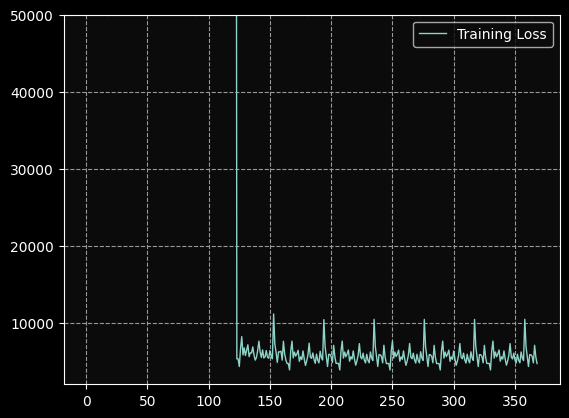

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from pylab import mpl, plt
torch.set_printoptions(threshold=10_000, sci_mode=False)
pd.options.display.max_columns = None
pd.options.display.max_rows = None


print("Welcome to the Bitcoin Price Prediction System...")

num_epochs = 3
# the size of each batch of data. The DataLoader will split our data into batches of 500 rows.
batch_size = 500
# our neural network
model = BTCNetwork()
# a function to calculate loss. This is mean squared error.
criterion = nn.MSELoss()
# an optimizer function. This will be used to update the weights and biases on our neural network
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
# an array to track historical performance. We will take a subset of the loss data and plot it to determine accuracy.
# our features. These are the inputs to our neural network
feature_columns = ["Previous_Low", "Previous_High", "Previous_Volume", "Previous_Weighted_Price"]
# our target. This is the column we are attempting to predict.
target_column = ["Close"]
print("Commence Training \n")

# get the feature and target data from our dataframe.
features = price_data[feature_columns]
targets = price_data[target_column]
print("features")
print(features.head())
print("TARGETS")
print(targets.head())
# split the data into training and testing batches. 20% of the data will be used for testing.
features_train, features_test, targets_train, targets_test = train_test_split(features,
                                                                             targets,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

# convert our training features into tensors.
featuresTrain = torch.from_numpy(features_train.values).float()
# convert our training targets into tensors.
targetsTrain = torch.from_numpy(targets_train.values).float()

# convert our testing features into tensors.
featuresTest = torch.from_numpy(features_test.values).float()
# convert our testing targets into tensors.
targetsTest = torch.from_numpy(targets_test.values).float()

# convert tensors into  tensor datasets...
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)
# and then add them to DataLoaders so we can iterate over them
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)




def train(train_loader, test_loader, num_epochs, criterion, optimizer):
  # keep track loss history
  hist = []
  # for every fifty iterations, collect loss data
  count = 50
  # iterate from zero to the desired number of epochs.
  for epoch in range(num_epochs):
      print(f"Epoch  {epoch+1}")
      # split the training data into batches, and iterate over batches.
      for i, (training_features, training_targets) in enumerate(train_loader):
          # reset the state of the optimizer and set the model to training mode.
          optimizer.zero_grad()
          model.train()
          # this is where the magic happens. We are finally inputting data into our model, and getting predictions as outputs.
          outputs = model(training_features)
          # calculate loss.
          loss = criterion(outputs, training_targets)
          # backpropogate through the network and update the optimizer
          loss.backward()
          optimizer.step()
          count += 1
          # if count is divisible by 20, we enter a testing loop
          if count % 50 == 0:
              with torch.no_grad():
                  # set the model to testing mode
                  model.eval()
                  # iterate over test batches
                  for j, (testing_features, testing_targets) in enumerate(test_loader):
                      # input test data, get outputs, compare the outputs to the targets and calculate loss
                      outputs = model(testing_features)
                      loss = criterion(outputs, testing_targets)
                      # only print and store loss data from the first iteration of each testing loop to save memory.
                      hist.append(loss.item())
                      if j == 0:
                          hist.append(loss.item())
                          print("Testing features: ", testing_features[0])
                          print("Testing target: ", testing_targets[0])
                          print("Outputs: ", outputs[0])
                          print("loss", loss.item())
          # return a history of loss for graphing
  return hist

loss = train(train_loader, test_loader, num_epochs, criterion, optimizer)
print("Training Complete")

# graph the loss data.
ax = plt.gca()
ax.set_ylim([2000, 50000])
plt.plot(loss, label='Training Loss')
plt.legend()
plt.show()

As you can see, training significantly improved the loss of this model. The loss starts at an extremely large number, and then gradually falls to a low around 5000. This may sound like a significant amount of loss, but when we consider the fact we are using mean squared error to calculate loss, it appears to be a relatively small amount of loss. That is because loss is calculated by taking the actual price squared minus the predicted price squared. Since bitcoin has an extremely high price, squaring these inputs creates very large numbers, so a loss of 5000 is still relatively small.  

One insight we can glean from the chart is that the model rapidly made large improvements in accuracy, but started to level off off before the 170th batch was run. We could improve this by trying different model structures, but for our purposes, this is sufficiently accurate.

The output above the chart will show you example predictions. We can see our inputs, labelled as testing features, along with our model prediction, labelled as outputs. We can also see the actual value, labelled testing target. On my previous run of this system, the last testing target showed 61044.9297, while the associated prediction was 60994.5078. This equates to a deviation of approximately .07% from the target price.

# Analysis and Conclusion

We can now analyze the predictions visually. We will start by adding a two new columns to our dataset: one representing predictions, and another column which tells us if our prediction was accurate. To define accuracy in this case, we will use a simple metric: if the prediction is between the previous low and previous high price, then we consider it accurate.

Run the code cell below to calculate the prediction and accuracy columns.

In [ ]:
rows = price_data
features = rows[feature_columns]
targets = rows[target_column]

feature_tensor = torch.from_numpy(features.values).float()
target_tensor = torch.from_numpy(targets.values).float()
output = model(feature_tensor)
plotted_rows = pd.DataFrame.copy(rows)
plotted_rows["Prediction"] = output.detach().numpy()

def accurate(row):
    if row['Low'] <= row['Prediction'] <= row['High']:
        return True
    return False
plotted_rows["accurate"] = plotted_rows.apply(accurate, axis=1)

## Graphing success
We can use a simple pychart to demonstrate how effective our system is at prediction bitcoin price.

The lines below will generate a pychart, showing success versus failure percentages.

([<matplotlib.patches.Wedge at 0x7e25b5e64df0>,
 [Text(-0.10640865958590222, 1.094841174401626, 'Correct Prediction'),
  Text(0.10640855707947251, -1.094841184364319, 'Incorrect Prediction')],
 [Text(-0.05804108704685575, 0.5971860951281596, '53.1%'),
  Text(0.05804103113425773, -0.5971861005623558, '46.9%')])

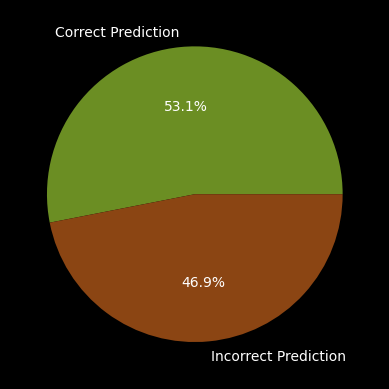

In [ ]:
import matplotlib.style

correct = plotted_rows["accurate"].value_counts()[True]
incorrect = plotted_rows["accurate"].value_counts()[False]
labels = ["Correct Prediction", "Incorrect Prediction"]
values = [correct, incorrect]
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=["olivedrab", "saddlebrown"], textprops={'color': 'white'})



## Plotting our Predictions
Let's use this model to graph predictions on a price chart. This will help us understand how accurate our predictions are, in a visual way. We can take a subset of our data to draw a chart, along with the predictions from our model. The chart will contain Japanese candle notation, along with a blue line representing our predictions. Below I have provided a line of code which takes one hour of data from the afternoon of the last day in our dataset.

I encourage the reader to tinker with the line below, to see the results for various time periods.

In [ ]:
month = int(input("Please pick a month. (1-3)\n") or 2)
day = int(input("Please pick a day (1-31)\n") or 15)
day = datetime.date(2021, month, day)

Please pick a month. (1-3)

Please pick a day (1-31)



In [ ]:
hour = int(input("Please pick an hour (0-23)\n") or 15)

Please pick an hour (0-23)



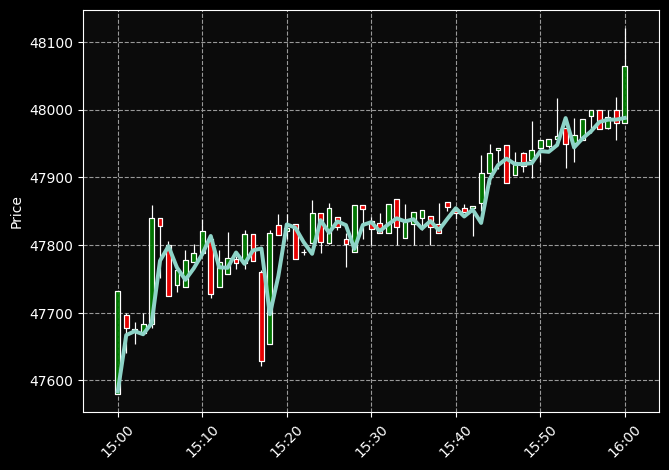

In [ ]:
try:
    day = dt.datetime.combine(day, dt.datetime.min.time())
    day = day.replace(hour=int(hour))
    end = day + dt.timedelta(hours=1)
    hourly = plotted_rows.loc[pd.to_datetime(day):pd.to_datetime(end)]
    mc = mplf.make_marketcolors(up='g',down='r',edge='white',volume='in',wick="white",ohlc='black')
    s  = mplf.make_mpf_style(marketcolors=mc, base_mpf_style='nightclouds')
    apdict = mplf.make_addplot(hourly['Prediction'])
    mplf.plot(hourly, type="candle", style=s, addplot=apdict)
except Exception as e:
    print("Failed to render chart. Did you select a day and hour in the inputs above?")
    print("If so, check the date. It must be between 9:00 am on 1/20/2021 and 5:00pm on 3/31/2021.")
    print(e)

## Conclusion
Our system was successfully able to predict a valid price 53.1% of the time. Given that this is a version one release, this is a resounding success. Future versions of this project may be able to increase the success percentage by training the model on more data, using a recurrent neural network model, and modifying the optimizer, loss function, and learning rate in the training loop.

With consistent development and training, this model will benefit our company immensely and ensure we may enter the cryptocurrency markets with minimal risk.